In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# unziping data downloaded from kaggle
#import os
#os.chdir('gdrive/My Drive')  #change dir
#!mkdir cnn  #create a directory named train/
#!unzip -q train.zip -d cnn/ #unzip data in train/
#!unzip -q test.zip -d cnn/  #unzip data in test/

In [3]:
# necessary imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import glob # FILE OPERATIONS
import itertools
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


scale = 64
seed = 7


Using TensorFlow backend.


In [4]:
# getting training images and resizing
training_images = glob.glob("/content/gdrive/My Drive/cnn/train/*/*png")
test_images = glob.glob("/content/gdrive/My Drive/cnn/test/*png")

train_set = []
train_labels = []

test_set = []
test_labels = []

print("number of images in train folder",len(training_images))
count = 1

for training_image in training_images:
    train_set.append(cv2.resize(cv2.imread(training_image),(scale,scale)))
    train_labels.append(training_image.split('/')[-2])
    count=count+1

count = 1
for test_image in test_images:
    test_set.append(cv2.resize(cv2.imread(test_image),(scale,scale)))
    test_labels.append(test_image.split('/')[-2])
    count=count+1

train_set = np.asarray(train_set)
train_labels = pd.DataFrame(train_labels)

test_set = np.asarray(test_set)
test_labels = pd.DataFrame(test_labels)

number of images in train folder 4750


12


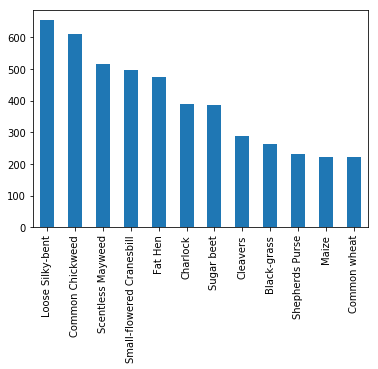

In [5]:
# getting training classes
labels = preprocessing.LabelEncoder()
labels.fit(train_labels[0])
# Converting a class vector to binary class matrix.
encodedlabels = labels.transform(train_labels[0])
categorical_labels = np_utils.to_categorical(encodedlabels)
classes = categorical_labels.shape[1]
print(str(classes))
train_labels[0].value_counts().plot(kind='bar')

## Divide the data set into Train and validation data sets

In [0]:
# normalizing the data for train and test to be between 0 -1
train_set = train_set/255

# train, test  split
x_train,x_test,y_train,y_test = train_test_split(train_set,categorical_labels,test_size=0.2,random_state=seed)

## Initialize & build the model
### Convolutional Neural Network

In [7]:
np.random.seed(seed)

cnn_model = tf.keras.Sequential()
tf.keras.initializers.he_normal(seed=seed)

cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), input_shape=(scale, scale, 3), activation='relu'))
#Normalize the data
cnn_model.add(tf.keras.layers.BatchNormalization())
# adding cnn layer
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# adding max pool layer
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#normalizing data
cnn_model.add(tf.keras.layers.BatchNormalization())
# adding dropout layer
cnn_model.add(tf.keras.layers.Dropout(0.1))

cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dropout(0.1))

cnn_model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dropout(0.1))
# Flattens the output from cnn layers
cnn_model.add(tf.keras.layers.Flatten())

cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dropout(0.5))

cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dropout(0.5))

cnn_model.add(tf.keras.layers.Dense(classes, activation='softmax'))



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Optimize the model

In [0]:
#Creating adam optimizer with learning rate
#sgd_optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=0.001)
adam_optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=0.001)


from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
callback_list = [early_stopping]# [stats, early_stopping]


#Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
#model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Model fitting for CNN

In [9]:
CDNN_model=cnn_model.fit(x_train,y_train,          
          validation_data=(x_test,y_test),
          epochs=20,
          batch_size=32, callbacks= callback_list)

Train on 3800 samples, validate on 950 samples
Epoch 1/20
3800/3800 [==============================] - 12s 3ms/sample - loss: 2.2788 - acc: 0.3576 - val_loss: 7.9415 - val_acc: 0.1600
Epoch 2/20
3800/3800 [==============================] - 9s 2ms/sample - loss: 1.4126 - acc: 0.5558 - val_loss: 15.1353 - val_acc: 0.1600
Epoch 3/20
3800/3800 [==============================] - 9s 2ms/sample - loss: 1.0577 - acc: 0.6595 - val_loss: 10.6401 - val_acc: 0.1737
Epoch 4/20
3800/3800 [==============================] - 9s 2ms/sample - loss: 0.8161 - acc: 0.7224 - val_loss: 3.2115 - val_acc: 0.2147
Epoch 5/20
3800/3800 [==============================] - 9s 2ms/sample - loss: 0.7172 - acc: 0.7692 - val_loss: 2.6109 - val_acc: 0.3653
Epoch 6/20
3800/3800 [==============================] - 9s 2ms/sample - loss: 0.6042 - acc: 0.7908 - val_loss: 0.8651 - val_acc: 0.6853
Epoch 7/20
3800/3800 [==============================] - 9s 2ms/sample - loss: 0.5449 - acc: 0.8184 - val_loss: 0.9816 - val_acc: 0.675

## Predict the accuracy for both train and validation data

In [10]:
print("Training Accuracy :",round(CDNN_model.history['acc'][-1]*100,2))#early stopping 
# validation accuracy
scores_cnn = cnn_model.evaluate(x_test, y_test, verbose=0)
print("Validation accuracy: " ,round(scores_cnn[1]*100,2))

Training Accuracy : 93.34
Validation accuracy:  85.58


## TEST data prediction

In [11]:
print ('Available Classes : ', labels.classes_)

Available Classes :  ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [12]:
test_set=test_set/255
# predictions using cnn model
prediction = cnn_model.predict(test_set)

pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]
print ('Predictions: ', predStr)

Predictions:  ['Common Chickweed' 'Cleavers' 'Loose Silky-bent' 'Sugar beet'
 'Small-flowered Cranesbill' 'Common Chickweed' 'Common Chickweed'
 'Common Chickweed' 'Common Chickweed' 'Cleavers' 'Loose Silky-bent'
 'Black-grass' 'Cleavers' 'Loose Silky-bent' 'Loose Silky-bent' 'Fat Hen'
 'Sugar beet' 'Cleavers' 'Cleavers' 'Loose Silky-bent' 'Sugar beet'
 'Scentless Mayweed' 'Fat Hen' 'Black-grass' 'Scentless Mayweed'
 'Shepherds Purse' 'Loose Silky-bent' 'Loose Silky-bent'
 'Common Chickweed' 'Sugar beet' 'Scentless Mayweed' 'Fat Hen'
 'Sugar beet' 'Loose Silky-bent' 'Common Chickweed' 'Black-grass'
 'Common Chickweed' 'Loose Silky-bent' 'Loose Silky-bent' 'Sugar beet'
 'Maize' 'Common Chickweed' 'Cleavers' 'Loose Silky-bent'
 'Scentless Mayweed' 'Loose Silky-bent' 'Sugar beet' 'Loose Silky-bent'
 'Common Chickweed' 'Fat Hen' 'Small-flowered Cranesbill'
 'Loose Silky-bent' 'Maize' 'Maize' 'Scentless Mayweed' 'Loose Silky-bent'
 'Small-flowered Cranesbill' 'Sugar beet' 'Scentless Mayweed